In [1]:
# Cell 1: Setup
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import pickle

In [4]:
# Cell 2: Load & prepare data
df = pd.read_csv("../data/cleaned_data.csv")

# Omvandla tid och skapa features
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
df["Hour"] = df["Time"].dt.hour
df["Weekday"] = df["Time"].dt.day_name()
df["Year"] = df["Time"].dt.year
df["Day_of_Year"] = df["Time"].dt.dayofyear

# Byt till engelska namn
df.rename(columns={
    "Månad": "Month",
    "Län": "County",
    "Kommun": "Municipality",
    "Art": "Species"
}, inplace=True)

# Ta bort rader utan viktiga features
df = df.dropna(subset=["County", "Species", "Weekday", "Hour", "Month", "Lat_WGS84", "Long_WGS84"])

# Skapa dummy-målvariabel (risklabel baserat på antal olyckor per grupp)
df["n_collisions"] = df.groupby(["County", "Species", "Month", "Hour"])["Time"].transform("count")
df["risk_label"] = pd.qcut(df["n_collisions"], 5, labels=["Very Low", "Low", "Moderate", "High", "Very High"])

# Features till modellen
features = [
    "Year", "Month", "Hour", "Weekday", "County",
    "Species", "Municipality", "Day_of_Year", "Lat_WGS84", "Long_WGS84"
]

X = df[features].copy()
y = df["risk_label"]

In [5]:
# Cell 3: Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [6]:
# Cell 4: Preprocessing pipeline
num_features = ["Month", "Hour", "Day_of_Year", "Lat_WGS84", "Long_WGS84"]
cat_features = ["Weekday", "County", "Species", "Municipality"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])

In [7]:
# Cell 5: Model pipeline
pipe = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [10, 20, None],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
    "clf__max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}


              precision    recall  f1-score   support

        High       0.86      0.87      0.87     31583
         Low       0.84      0.79      0.81     31198
    Moderate       0.85      0.82      0.83     31519
   Very High       0.89      0.97      0.93     31531
    Very Low       0.91      0.90      0.90     32551

    accuracy                           0.87    158382
   macro avg       0.87      0.87      0.87    158382
weighted avg       0.87      0.87      0.87    158382



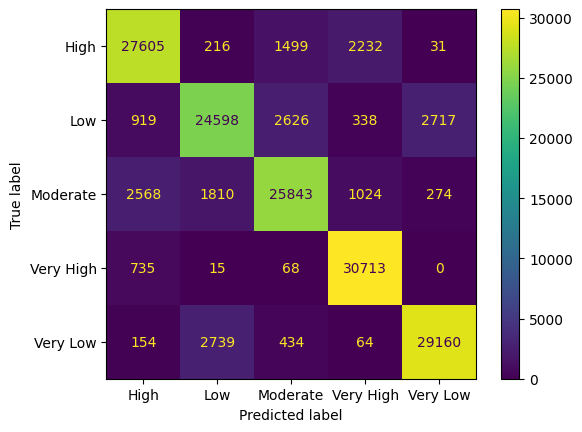

In [8]:
# Cell 6: Evaluation
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test)
plt.show()

In [9]:
# Cell 7: Save model and columns
model = grid.best_estimator_

# Spara modellen
os.makedirs("model", exist_ok=True)
joblib.dump(model, "model/model.pkl")

# Spara feature columns efter one-hot encoding
feat_names = model.named_steps["pre"].get_feature_names_out()
with open("model/model_columns.pkl", "wb") as f:
    pickle.dump(feat_names.tolist(), f)

print("✅ Model and columns saved.")

✅ Model and columns saved.
